<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/transposed_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transposed Conv

In [2]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [4]:
import numpy as np
import torch
from torchvision import transforms
from torch import optim, nn
from torch.nn import functional as F
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils

### Transposed Convのスクラッチ実装

In [5]:
def conv_transpose2d(input, weight, stride=1, padding=0):
    batch_size, ch_in, h_in, w_in = input.shape
    _, ch_out, f_h, f_w = weight.shape

    h_out = stride * (h_in - 1) + f_h - 2*padding
    w_out = stride * (w_in - 1) + f_w - 2*padding

    output = torch.zeros((batch_size, ch_out, h_out, w_out))

    for b in range(batch_size):
        for i in range(ch_in):
            for o in range(ch_out):
                for h in range(h_in):
                    for w in range(w_in):
                        h_start = h * stride - padding
                        w_start = w * stride - padding
                        for f_h_idx in range(f_h):
                            for f_w_idx in range(f_w):
                                # 出力位置の計算
                                h_out_idx = h_start + f_h_idx
                                w_out_idx = w_start + f_w_idx

                                if 0 <= h_out_idx < h_out and 0 <= w_out_idx < w_out:
                                    output[b, o, h_out_idx, w_out_idx] += input[b, i, h, w] * weight[i, o, f_h_idx, f_w_idx]

    return output

In [10]:
input = torch.randn(1, 3, 5, 5)
convt_layer = nn.ConvTranspose2d(3, 4, kernel_size=3, stride=2, padding=2, bias=False)
weight = convt_layer.weight

output_scratch = conv_transpose2d(input, weight)
output = convt_layer(input)

# 出力の形状が同じであることを確認する
print(f"スクラッチ：{output_scratch.shape}")
print(f"Pytorch：{output.shape}")

スクラッチ：torch.Size([1, 4, 7, 7])
Pytorch：torch.Size([1, 4, 7, 7])


## Autoencoder

In [35]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2)

    def forward(self, x):
        # 1x28x28
        out = self.pool(self.relu(self.conv1(x)))
        # 16x14x14
        out = self.pool(self.relu(self.conv2(out)))
        # 4x7x7
        out = self.relu(self.t_conv1(out))
        # 16x14x14
        out = F.sigmoid(self.t_conv2(out))
        # 1x28x28
        return out

In [18]:
# データ準備
transform = transforms.ToTensor()
train_dataset = MNIST('./mnist_data', train=True, download=True, transform=transform)
val_dataset = MNIST('./mnist_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [36]:
model = ConvAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [37]:
# 学習ループ
for epoch in range(1, epochs+1):
    train_loss = 0.0
    for X, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(X)
        loss = F.mse_loss(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*X.shape[0]
    train_loss = train_loss / len(train_loader)
    print(f'Epoch: {epoch}: train loss: {train_loss}')

Epoch: 1: train loss: 9.304423572539266
Epoch: 2: train loss: 2.26352802230351
Epoch: 3: train loss: 1.7975749056984875
Epoch: 4: train loss: 1.6518154319669647
Epoch: 5: train loss: 1.5625443192306103
Epoch: 6: train loss: 1.4931573299710938
Epoch: 7: train loss: 1.4426959180501477
Epoch: 8: train loss: 1.402897328201896
Epoch: 9: train loss: 1.3686655901515408
Epoch: 10: train loss: 1.3368353570448055


In [38]:
# 検証データで実際に予測してみる
val_loader = DataLoader(val_dataset, batch_size=8)
images, labels = next(iter(val_loader))
outputs = model(images)

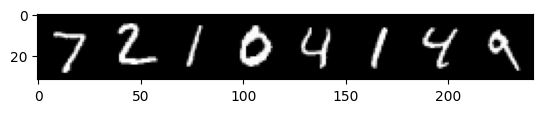

In [39]:
# 予測結果可視化
images_grid = make_grid(images)
outputs_grid = make_grid(outputs)
# 元の画像
plt.imshow(torch.permute(images_grid, (1, 2, 0)))

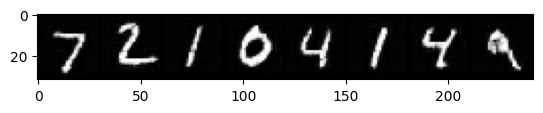

In [40]:
# 出力結果
plt.imshow(torch.permute(outputs_grid, (1, 2, 0)))